In [46]:
from __helpers import qubit_expansion, rand_basis
from ___constants import PARAM_PER_QUBIT_PER_DEPTH
from __loss_funcs import KL
from __class_BasisTransformer import BasisTransformer
from __class_PQC import PQC
from __class_HQNet import HQNet
import matplotlib.pyplot as plt
import numpy as np
from math import pi
from qiskit.quantum_info import Statevector
%matplotlib inline

In [47]:

# Useful additional packages 
import matplotlib.pyplot as plt
import numpy as np
from math import pi

from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile
from qiskit.tools.visualization import circuit_drawer
from qiskit.quantum_info import state_fidelity
from qiskit import BasicAer
from qiskit.quantum_info import Operator
from qiskit.quantum_info import Statevector
import torch




"""
q = QuantumRegister(2)

qc = QuantumCircuit(q)
qc.u(pi,0,pi,q[0])
qc.draw()
"""


#lets create GHZ state
circ = QuantumCircuit(3)
# Add a H gate on qubit 0, putting this qubit in superposition.
circ.h(0)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 1, putting
# the qubits in a Bell state.
circ.cx(0, 1)
# Add a CX (CNOT) gate on control qubit 0 and target qubit 2, putting
# the qubits in a GHZ state.
circ.cx(0, 2)
# Set the intial state of the simulator to the ground state using from_int
state = Statevector.from_int(0, 2**3)
state1 = state.copy()
# Evolve the state by the quantum circuit
state = state.evolve(circ)
print(state)
print(state1)

Statevector([0.70710678+0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.        +0.j, 0.        +0.j,
             0.        +0.j, 0.70710678+0.j],
            dims=(2, 2, 2))
Statevector([1.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j, 0.+0.j,
             0.+0.j],
            dims=(2, 2, 2))


            ┌───┐          
q1185253_0: ┤ H ├──■────■──
            └───┘┌─┴─┐  │  
q1185253_1: ─────┤ X ├──┼──
                 └───┘┌─┴─┐
q1185253_2: ──────────┤ X ├
                      └───┘


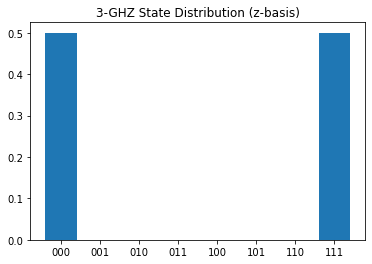

In [48]:
CIRCUIT_DEPTH = 0 # Depth of the parameterized quantum circuit
STATE_TYPE = 'GHZ'
NUM_QUBITS = 3
USE_REGULARIZER = False


"""[Notes on the states]

Confusingly, the cluster state is actually NUM_QUBITS^2 qubits rather than NUM_QUBITS. 
This is due to the way the circuit is designed. The rest are as you would expect.
"""

if STATE_TYPE == 'GHZ':
    # Prepare: GHZ State (from: Q-circuit)
    from GHZ_generator import GHZ_state_circuit
    state = Statevector.from_int(0, 2**NUM_QUBITS)
    qc = GHZ_state_circuit(L=NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
elif STATE_TYPE == 'XY':
    # Prepare: XY(L) (from: ED)
    from XY_generator import xy_ground_state
    state = Statevector(xy_ground_state(NUM_QUBITS).numpy())
elif STATE_TYPE == 'Cluster':
    # Prepare cluster(L) (from: Q-circuit)
    from cluster_generator import cluster_state_circuit
    state = Statevector.from_int(0, 2**(NUM_QUBITS**2))
    qc = cluster_state_circuit(NUM_QUBITS)
    print(qc)
    state = state.evolve(qc)
else:
    raise TypeError("Invalid state type specified.")
param_shape = (state.num_qubits, CIRCUIT_DEPTH+1, PARAM_PER_QUBIT_PER_DEPTH)

# Visualize the distribution
plt.bar(qubit_expansion(state.num_qubits), state.probabilities())
plt.title(f"{NUM_QUBITS}-{STATE_TYPE} State Distribution (z-basis)")
plt.show()

In [49]:
#function that apply the KS test to two probability list
def KS(P1, P2):
    assert len(P1) == len(P2)
    cdf1 = [P1[0]]
    cdf2 = [P2[0]]
    for i in range(len(P1)-1):
        cdf1.append(cdf1[i] + P1[i+1])
        cdf2.append(cdf2[i] + P2[i+1])
    difference = torch.tensor(cdf1) - torch.tensor(cdf2)

    #print(difference)
    return torch.pow(difference, 2).sum()#difference.abs().max().item()

print(KS([0.2, 0.8], [0.5, 0.5]))


def KL(P1, P2):
    Q = torch.tensor(P1)
    Q = Q + 0.00001 * torch.ones(Q.size())
    P = torch.tensor(P2)
    P = P + 0.00001 * torch.ones(Q.size())
    #print(Q)
    #tens = torch.div(P, Q)
    #tens = 
    return (torch.log(torch.div(P, Q)) * P).sum().item()

print(KL([0, 1], [0.5, 0.5]))

tensor(0.0900)
5.063431739807129


In [50]:
from torch.nn import functional as F
import torch.nn as nn

#This is our KS network duh
class KS_net(nn.Module):
    def __init__(self):
        super(KS_net, self).__init__()
        self.linear1 = nn.Linear(9, 20)
        self.linear2 = nn.Linear(20, 20)
        self.linear3 = nn.Linear(20, 1)
    
    def forward(self, param):
        x = F.leaky_relu(self.linear1(param))
        #print(x)
        x = F.leaky_relu(self.linear2(x))
        #print(x)
        x = F.leaky_relu(self.linear3(x))
        return x


class CONV3(nn.Module):
    def __init__(self):
        super(CONV3, self).__init__()
        self.conv1 = nn.Conv2d(1, 4, (1,3))
        self.conv2 = nn.Conv2d(4, 20, (1,1))
        self.linear1 = nn.Linear(60, 20)
        self.linear2 = nn.Linear(20, 20)
        self.linear3 = nn.Linear(20,1)
    
    def forward(self, param):
        #print(param.size())
        x = param.view(-1, 3,3)
        
        x = torch.unsqueeze(x, 1)
       #print(x.size())
        x = F.leaky_relu(self.conv1(x))
        x = F.leaky_relu(self.conv2(x))
        x = x.view(-1, 60)
        x = F.leaky_relu(self.linear1(x))
        #print(x)
        x = F.leaky_relu(self.linear2(x))
        x = F.leaky_relu(self.linear3(x))
        return x

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


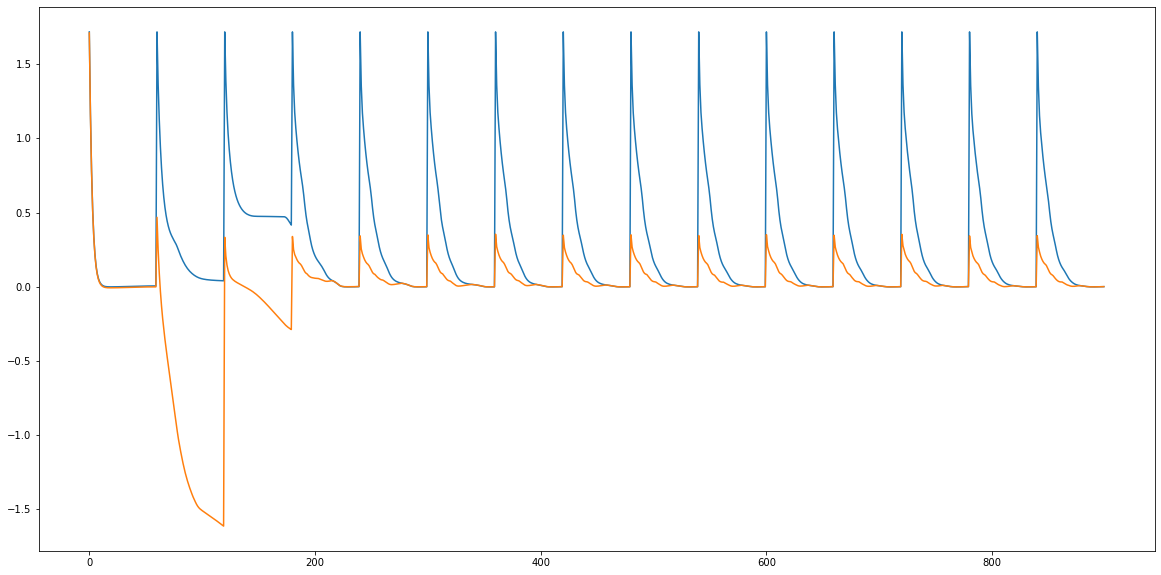

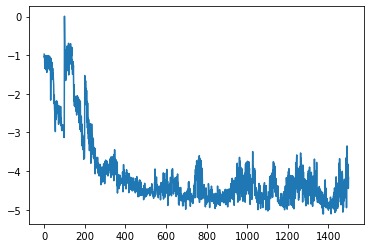

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


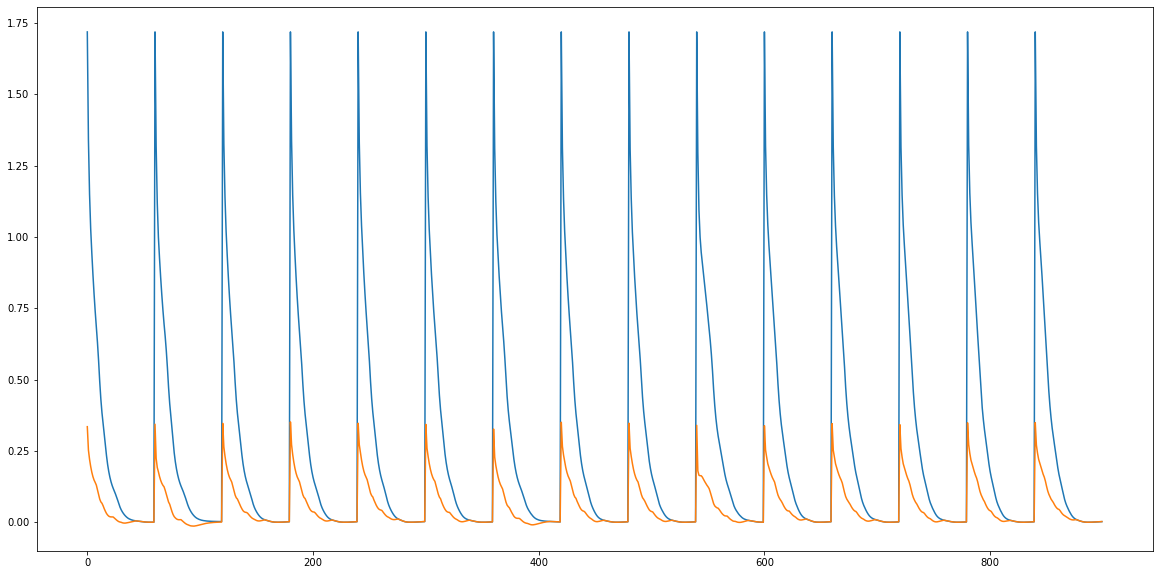

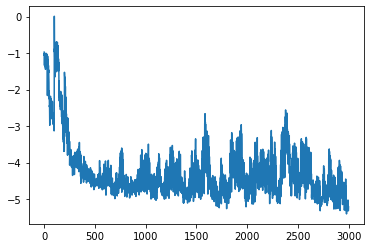

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


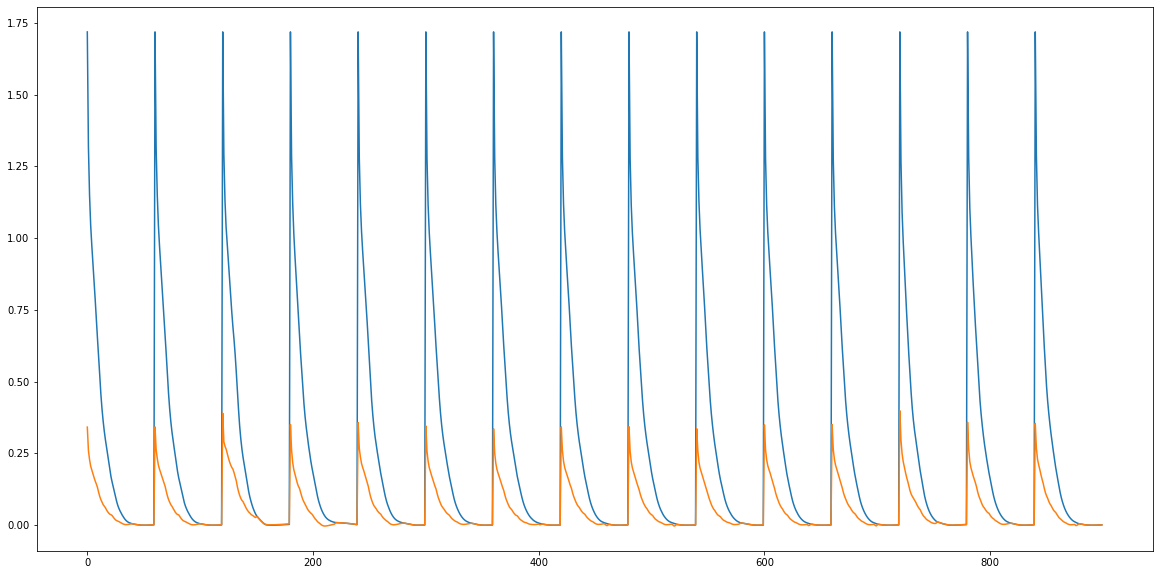

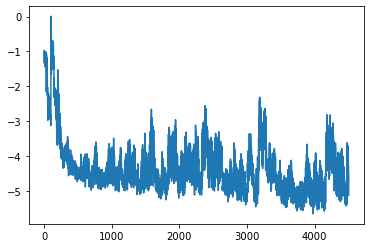

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14


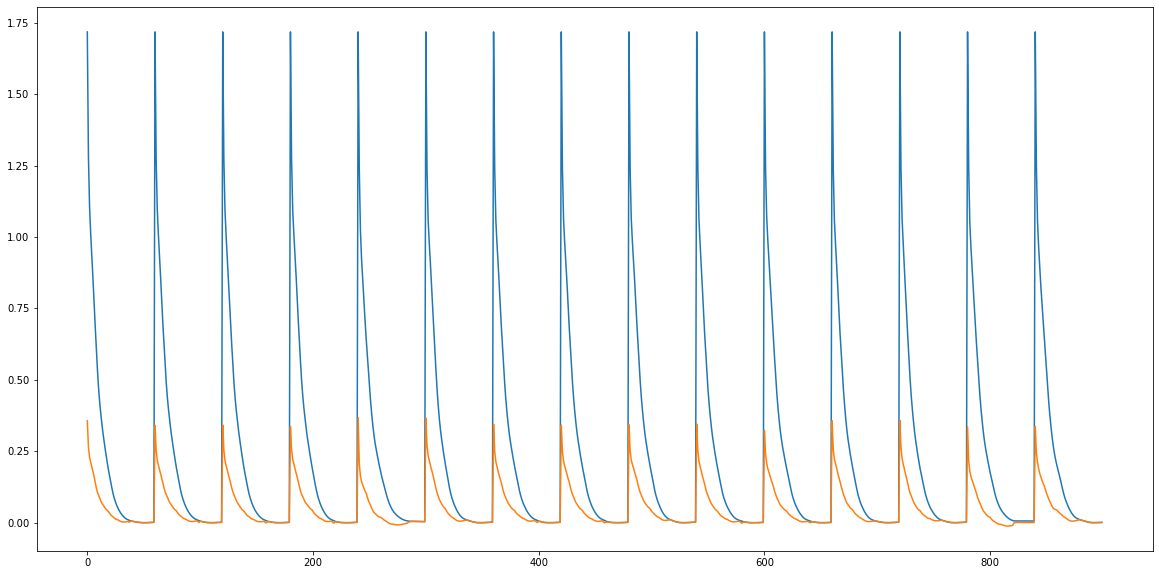

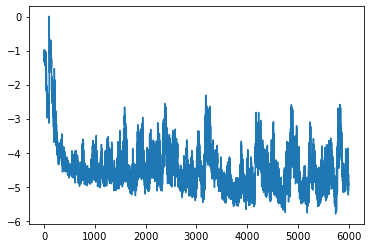

0
1
2
3
4
5
6
7
8
9
10


KeyboardInterrupt: 

In [69]:
#this is where we try to learn the symmetry
import random


ls1 = [] #loss with regularization
ls2 = [] #nn training loss

class SymFinder():
  def __init__(self, eta, step_size):
    self.parameters = torch.randint(0, 100, (3, 3)) * pi /100
    #parameters[i,0] is the theta for ith qubit, 1 is \phi, 2 is lambda
    self.original_state = state
    self.transformed_state = None
    self.param_rate = eta # this is the learning rate for updating parameter
    self.step_size = step_size
    self.losses = []
    self.known_symmetries = []

    #now these are the nn attributes
    self.data = torch.zeros(30000, 10) #data for training KS_net, 9 + 1 = param + value
    self.data.requires_grad = False
    self.learn_rate = 0.01 #learning rate for training KS_net
    self.model = CONV3()
    self.batch_size = 50 #batch for SGD
    self.optimizer = torch.optim.Adam(self.model.parameters(), lr = self.learn_rate)
    self.loss_func = nn.MSELoss()
    self.memory_pointer = 0 #tell where to store new data
    self.valid_range = 0#how much valid data is in the tensor, dont want to learn 00000

    #these are attributes for putting the nn and KS together
    self.reg_constant = 0.5
    self.KS_threshold = 0.05 #if less than value, declare it as symmetry
    #self.model2 = KS_net()
    #self.model2.load_state_dict(self.model.state_dict())

  
  #return a transformed state according to parameter
  def transform(self, p):
    q = QuantumRegister(3)
    qc = QuantumCircuit(q)
    qc.u(p[0,0].item(),p[0,1].item(),p[0,2].item(),q[0])
    qc.u(p[1,0].item(),p[1,1].item(),p[1,2].item(),q[1])
    qc.u(p[2,0].item(),p[2,1].item(),p[2,2].item(),q[2])
    return self.original_state.copy().evolve(qc)
  

  
  def change_basis(self, state1, state2):
    q = QuantumRegister(3)
    qc = QuantumCircuit(q)
    qc.u(pi/10, 0, 0, q[0])
    qc.u(0*pi/10, 0, 0, q[1])
    qc.u(pi/10, 0, 0, q[2])
    return state1.copy().evolve(qc), state2.copy().evolve(qc)

  #return the loss from KS test of original vs another state
  def calculate_loss(self, state2, param):
    #get the probability in the original basis
    P1 = self.original_state.probabilities()
    P2 = state2.probabilities()
    #now we calculate probability in another basis
    new_state1, new_state2 = self.change_basis(self.original_state, state2)
    Q1 = new_state1.probabilities()
    Q2 = new_state2.probabilities()
    #lets add regularizer from our nn
    true_loss = KL(P1, P2) +  KL(Q1, Q2)
    v = self.model(param.view(9)).detach_()
    #addon = 20 * torch.tanh(1/((v-true_loss)**2))
    addon = -0.8 * v
    #v = 0
    return [true_loss + addon, true_loss]
  

  def update_KS_net(self):
    #this function use the data gathered to update KS_net parameters
    for i in range(100):
      self.optimizer.zero_grad()
      num = min(self.valid_range, self.data.size(0))
      #print(num, self.batch_size)
      indices = random.sample(range(num), min(self.batch_size, num))
      sampled_data = self.data[indices].clone()
      target = sampled_data[:, 9] #actual KS_value
      current = self.model(sampled_data[:, 0:9]).squeeze()
      loss = self.loss_func(current, target)
      ls2.append(loss.item())
      #print(loss)
      loss.backward()
      self.optimizer.step()
    
  def update_param(self):
    #calculate the gradient using good old finite difference:
    cur_state = self.transform(self.parameters)
    cur_loss = self.calculate_loss(cur_state, self.parameters)[0]
    cur_true_loss = self.calculate_loss(cur_state, self.parameters)[1]
    #lets store this data
    self.data[self.memory_pointer, 0:9] = self.parameters.reshape(9)
    self.data[self.memory_pointer, 9] = cur_true_loss
    self.memory_pointer = (self.memory_pointer + 1) % self.data.size(0)
    self.valid_range = self.valid_range + 1
    grad = torch.zeros(3,3)
    for i in range(3):
        for j in range(3):
            new_param = self.parameters.clone()
            new_param[i,j] = new_param[i,j] + self.step_size
            new_state = self.transform(new_param)
            new_loss = self.calculate_loss(new_state, new_param)[0]
            grad[i,j] = (new_loss - cur_loss) / self.step_size
    #update the parameters:
    self.parameters = self.parameters - self.param_rate * grad
    #self.parameters.requires_grad = False
    #self.parameters[:, 2] = torch.zeros(3)
    ls1.append(cur_loss)
    return cur_true_loss
  



  def symfinding(self):

    #self.parameters = torch.randint(0, 100, (3, 3)) * 2 * pi /100
    self.parameters = 0.5 * torch.ones(3,3)
    for i in range(60):
      cur_true_loss = self.update_param()
      self.losses.append(cur_true_loss)
      if cur_true_loss < self.KS_threshold:
        self.known_symmetries.append(self.parameters.clone())
        #break



  def train(self):
    for i in range(10):
      self.symfinding()
      self.update_KS_net()
      print(i)
      #self.model2.load_state_dict(self.model.state_dict())


  def current_matrix(self):
    p = self.parameters
    #p[0,:] = torch.tensor([3.14159, 0,3.1415926])
    u0 = torch.tensor([[torch.cos(p[0,0]/2), -torch.exp(-p[0,2]*1j)*torch.sin(p[0,0]/2)],\
                    [torch.exp(p[0,1]*1j)*torch.sin(p[0,0]/2), torch.exp((p[0,1] + p[0,2])*1j)*torch.cos(p[0,0]/2)]])
    u1 = torch.tensor([[torch.cos(p[1,0]/2), -torch.exp(-p[1,2]*1j)*torch.sin(p[1,0]/2)],\
                    [torch.exp(p[1,1]*1j)*torch.sin(p[1,0]/2), torch.exp((p[1,1] + p[1,2])*1j)*torch.cos(p[1,0]/2)]])
    u2 = torch.tensor([[torch.cos(p[2,0]/2), -torch.exp(-p[2,2]*1j)*torch.sin(p[2,0]/2)],\
                    [torch.exp(p[2,1]*1j)*torch.sin(p[2,0]/2), torch.exp((p[2,1] + p[2,2])*1j)*torch.cos(p[2,0]/2)]])
    return [u0, u1, u2]
        
        
        
        

import numpy as np

finder = SymFinder(0.03, 0.1)

start = 0

for i in range(10):
  finder.train()
  plt.figure(figsize=(20, 10))
  plt.plot(range(len(finder.losses[start:])), (finder.losses[start:]))
  plt.plot(range(len(finder.losses[start:])), (ls1[start:]))
  plt.show()
  plt.plot(range(len(ls2)), np.log10(ls2))
  plt.show()
  start = len(finder.losses)

  
  
  

  


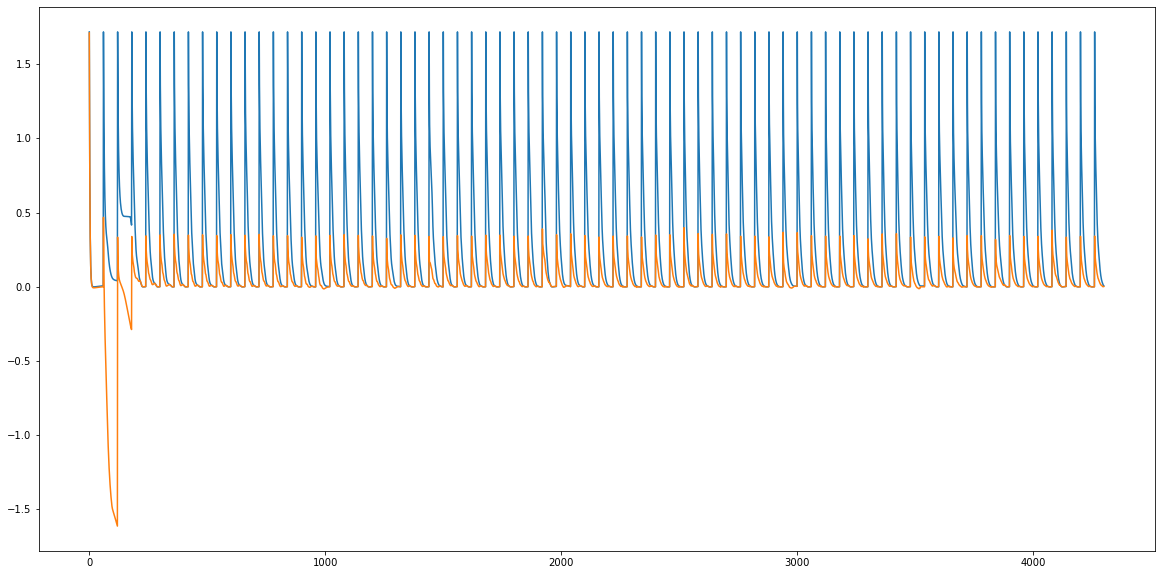

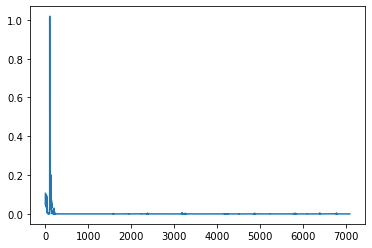

In [70]:
plt.figure(figsize=(20, 10))
plt.plot(range(len(finder.losses)), finder.losses)
plt.plot(range(len(finder.losses)), ls1)



plt.show()


plt.plot(range(len(ls2)), ls2)
plt.show()



<ipython-input-71-89c64704073f>:4: RuntimeWarning: invalid value encountered in log10
  plt.plot(range(len(finder.losses)), np.log10(ls1))


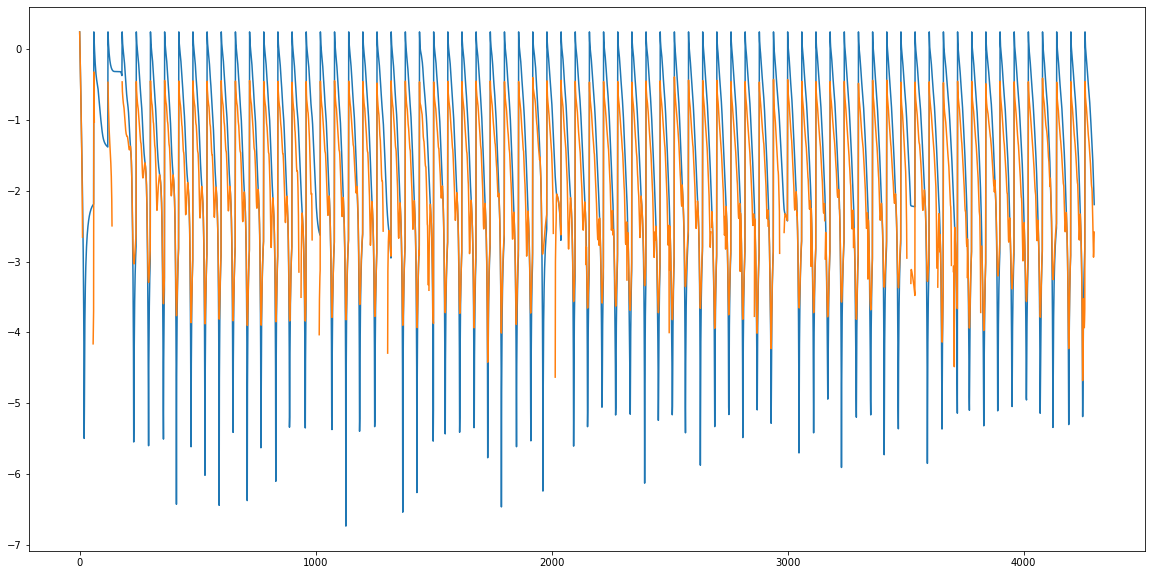

0.05418143105077172
tensor([[0.0543]])
---
0.05249729018242623
tensor([[0.0523]])
---
0.051064351595050746
tensor([[0.0505]])
---
0.049832607786805524
tensor([[0.0489]])
---
0.048762623528283734
tensor([[0.0475]])
---
0.04782296059092983
tensor([[0.0462]])
---
0.046988709477126196
tensor([[0.0450]])
---
0.046239709341420056
tensor([[0.0439]])
---
0.04555992269813262
tensor([[0.0428]])
---
0.04495849524092968
tensor([[0.0419]])
---
here is the matrix 0
tensor([[ 1.0000+0.0000j, -0.0083+0.0045j],
        [ 0.0082+0.0046j,  0.5389+0.8423j]])
tensor([[ 1.0000+0.0000j, -0.0064+0.0035j],
        [ 0.0064+0.0035j,  0.5409+0.8411j]])
tensor([[ 1.0000+0.0000j, -0.0083+0.0045j],
        [ 0.0083+0.0046j,  0.5371+0.8435j]])
here is the statevector
Statevector([ 0.70702503-4.57800763e-07j,  0.00579185+3.26599354e-03j,
              0.00450686+2.54514848e-03j,  0.00536971-3.97205319e-03j,
              0.0058211 +3.29111578e-03j,  0.00418408-3.02941177e-03j,
              0.00534435-3.94264430e-03j

In [71]:
plt.figure(figsize=(20, 10))

plt.plot(range(len(finder.losses)), np.log10(finder.losses))
plt.plot(range(len(finder.losses)), np.log10(ls1))

plt.show()




for i in range(10):
    #parameters = torch.randint(0, 100, (3, 3)) * 2 * pi /100
    i = i+100
    parameters = finder.data[i, 0: 9].reshape(3,3)
    #parameters = finder.known_symmetries[i]
    #trained_value = finder.data[i, 9]
    state2 = finder.transform(parameters)
    #print(parameters)
    print(finder.calculate_loss(state2, parameters)[1])
    print(finder.model(parameters.view(9)).detach_())
    print("---")



def matrix(p):
    #p[0,:] = torch.tensor([3.14159, 0,3.1415926])
    u0 = torch.tensor([[torch.cos(p[0,0]/2), -torch.exp(-p[0,2]*1j)*torch.sin(p[0,0]/2)],\
                    [torch.exp(p[0,1]*1j)*torch.sin(p[0,0]/2), torch.exp((p[0,1] + p[0,2])*1j)*torch.cos(p[0,0]/2)]])
    u1 = torch.tensor([[torch.cos(p[1,0]/2), -torch.exp(-p[1,2]*1j)*torch.sin(p[1,0]/2)],\
                    [torch.exp(p[1,1]*1j)*torch.sin(p[1,0]/2), torch.exp((p[1,1] + p[1,2])*1j)*torch.cos(p[1,0]/2)]])
    u2 = torch.tensor([[torch.cos(p[2,0]/2), -torch.exp(-p[2,2]*1j)*torch.sin(p[2,0]/2)],\
                    [torch.exp(p[2,1]*1j)*torch.sin(p[2,0]/2), torch.exp((p[2,1] + p[2,2])*1j)*torch.cos(p[2,0]/2)]])
    return [u0, u1, u2]
i=0
for p in finder.known_symmetries:
    parameters = p
    state2 = finder.transform(parameters)
    if finder.calculate_loss(state2, parameters)[1] < 0.001:
        print("here is the matrix",i)
        i=i+1
        print(matrix(p)[0])
        print(matrix(p)[1])
        print(matrix(p)[2])
        print("here is the statevector")
        print(finder.transform(p))
        print("---")






In [61]:
p = finder.known_symmetries[5]
print(matrix(p)[0][1,0] * matrix(p)[1][1,0] * matrix(p)[2][1,0])
print(matrix(p)[0][0,1] * matrix(p)[1][0,1] * matrix(p)[2][0,1])
print(matrix(p)[0][1,1] * matrix(p)[1][1,1] * matrix(p)[2][1,1])
print(matrix(p)[0][0,1] * matrix(p)[1][0,1] * matrix(p)[2][0,1])

tensor(-3.3096e-05-9.2134e-06j)
tensor(3.3064e-05+9.3252e-06j)
tensor(0.9984-0.0034j)
tensor(3.3064e-05+9.3252e-06j)
